In [568]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.cluster import KMeans
from scipy.stats import uniform
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
df = pd.read_csv('ecommerce_customer_data_custom_ratios.csv')

df.head()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,46251,2020-09-08 09:38:32,Electronics,12,3,740,Credit Card,37,0.0,Christine Hernandez,37,Male,0
1,46251,2022-03-05 12:56:35,Home,468,4,2739,PayPal,37,0.0,Christine Hernandez,37,Male,0
2,46251,2022-05-23 18:18:01,Home,288,2,3196,PayPal,37,0.0,Christine Hernandez,37,Male,0
3,46251,2020-11-12 13:13:29,Clothing,196,1,3509,PayPal,37,0.0,Christine Hernandez,37,Male,0
4,13593,2020-11-27 17:55:11,Home,449,1,3452,Credit Card,49,0.0,James Grant,49,Female,1


In [569]:
df.describe()

,Customer ID,Product Price,Quantity,Total Purchase Amount,Customer Age,Returns,Age,Churn
count,250000.00000,250000.000000,250000.000000,250000.000000,250000.000000,202404.000000,250000.000000,250000.000000
mean,25004.03624,254.659512,2.998896,2725.370732,43.940528,0.497861,43.940528,0.199496
std,14428.27959,141.568577,1.414694,1442.933565,15.350246,0.499997,15.350246,0.399622
min,1.00000,10.000000,1.000000,100.000000,18.000000,0.000000,18.000000,0.000000
25%,12497.75000,132.000000,2.000000,1477.000000,31.000000,0.000000,31.000000,0.000000
50%,25018.00000,255.000000,3.000000,2724.000000,44.000000,0.000000,44.000000,0.000000
75%,37506.00000,377.000000,4.000000,3974.000000,57.000000,1.000000,57.000000,0.000000
max,50000.00000,500.000000,5.000000,5350.000000,70.000000,1.000000,70.000000,1.000000


In [570]:
df = df.drop(columns=['Age'])

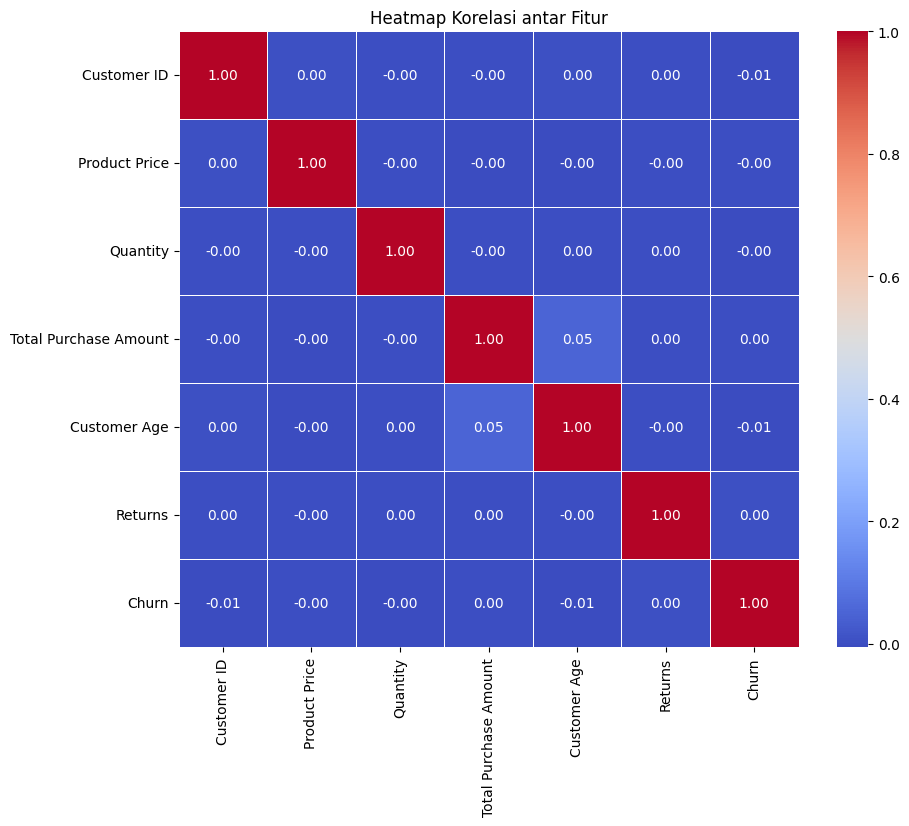

In [571]:
correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap Korelasi antar Fitur')
plt.show()

In [572]:
df.duplicated().sum()

np.int64(0)

In [573]:
df.isna().sum()

Customer ID                  0
Purchase Date                0
Product Category             0
Product Price                0
Quantity                     0
Total Purchase Amount        0
Payment Method               0
Customer Age                 0
Returns                  47596
Customer Name                0
Gender                       0
Churn                        0
dtype: int64

In [574]:
if df.shape[0] > 1000:
    np.random.seed(42)
    sample_idx = np.random.choice(df.index, 1000, replace=False)
    representative_sample = df.loc[sample_idx]
else:
    representative_sample = df

In [575]:
representative_sample['Returns'] = representative_sample['Returns'].fillna(0)

In [576]:
representative_sample['Gender'] = LabelEncoder().fit_transform(representative_sample['Gender'])

In [577]:
unsupervised_df = representative_sample[['Total Purchase Amount', 'Product Price', 'Customer Age', 'Quantity']].copy()

In [578]:
def remove_outliers_iqr(dataframe, columns):
    for col in columns:
        Q1 = dataframe[col].quantile(0.25)
        Q3 = dataframe[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        dataframe = dataframe[(dataframe[col] >= lower_bound) & (dataframe[col] <= upper_bound)]
    return dataframe

In [579]:
unsupervised_df = remove_outliers_iqr(unsupervised_df, unsupervised_df.columns)

In [580]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(unsupervised_df)

In [581]:
def visualization(df, column_name):
    plt.figure(figsize=(18, 5))
    
    plt.subplot(1, 3, 1)
    sns.histplot(df[column_name], kde=True, bins=30, color='skyblue')
    plt.title(f'Histogram of {column_name}')
    plt.xlabel(column_name)
    
    plt.subplot(1, 3, 2)
    stats.probplot(df[column_name], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {column_name}')
    
    plt.subplot(1, 3, 3)
    sns.boxplot(x=df[column_name], color='orange')
    plt.title(f'Boxplot of {column_name}')
    
    plt.tight_layout()
    plt.show()

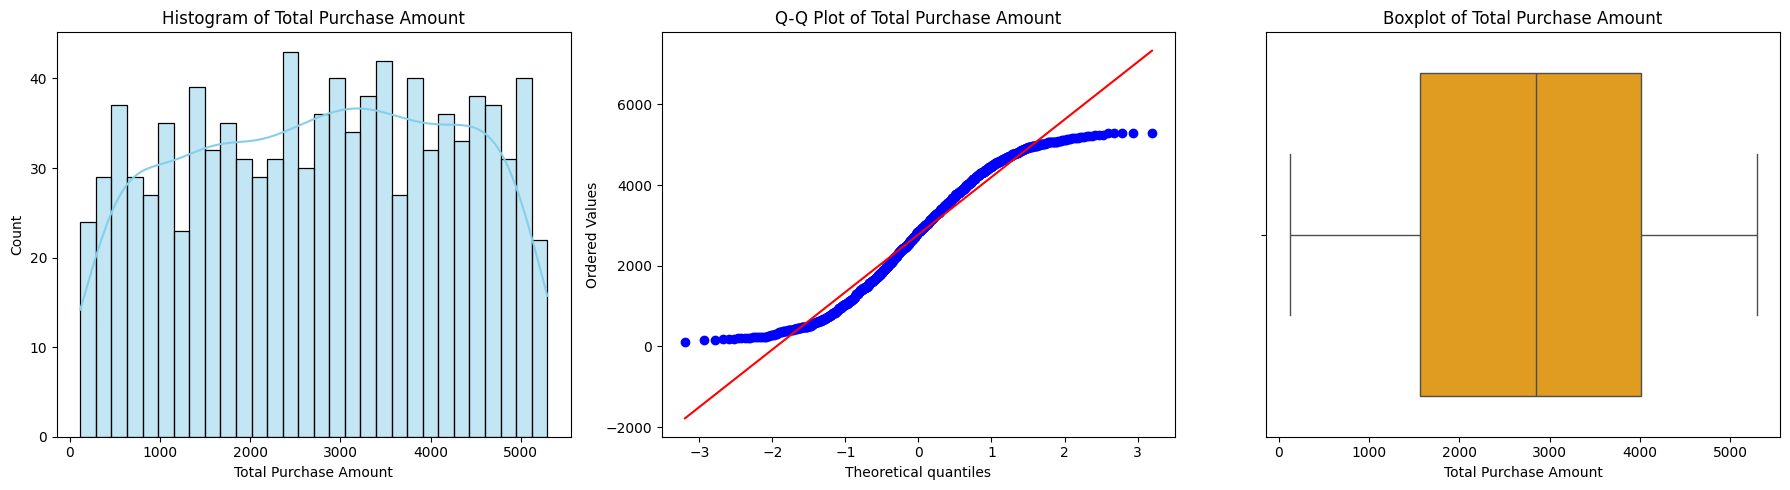

In [582]:
visualization(unsupervised_df, 'Total Purchase Amount')

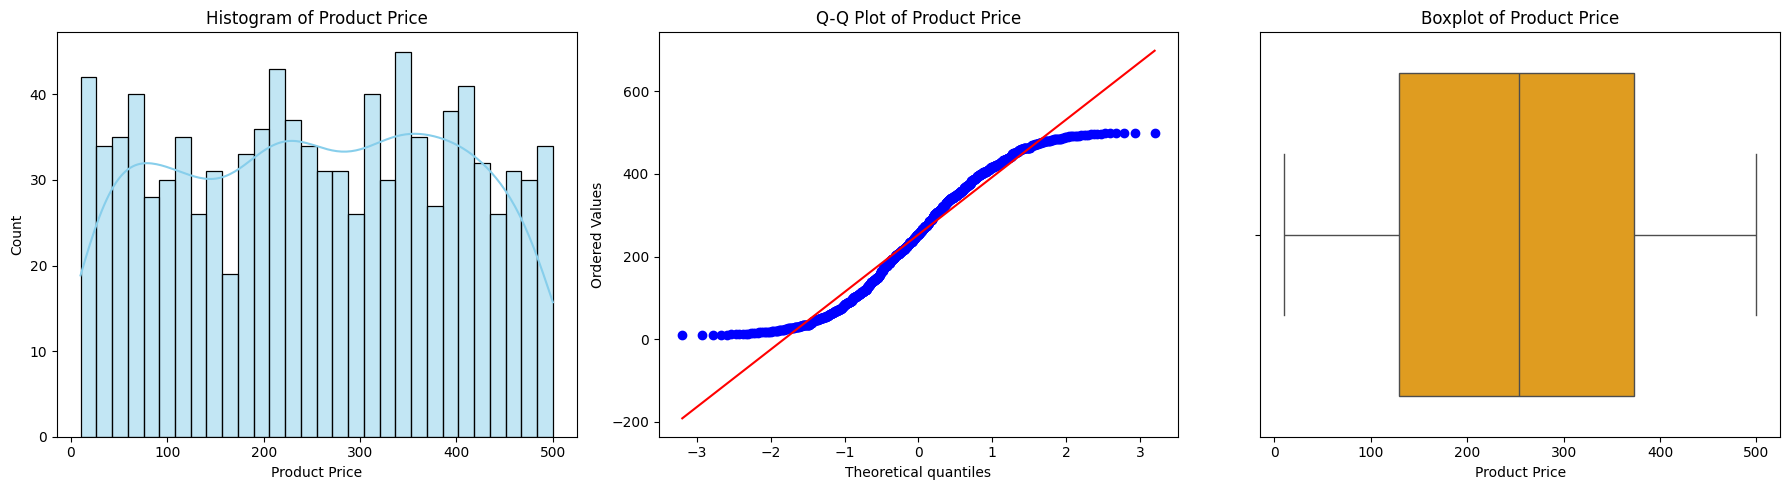

In [583]:
visualization(unsupervised_df, 'Product Price')

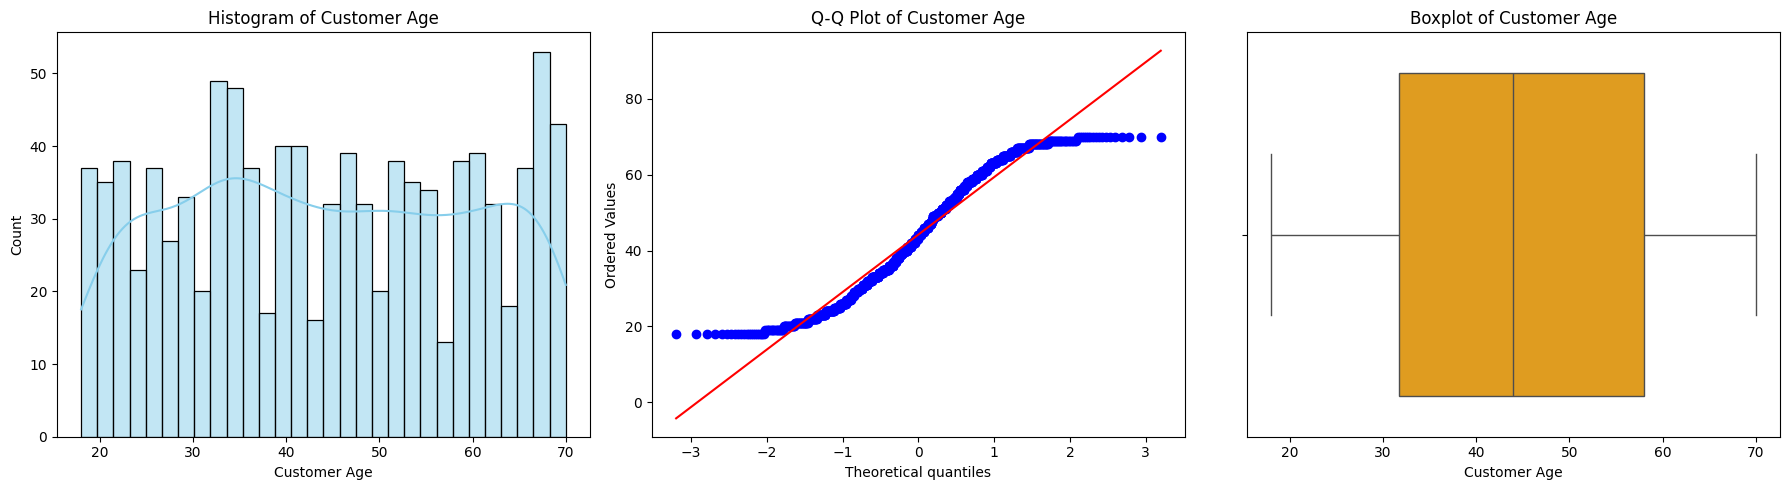

In [584]:
visualization(unsupervised_df, 'Customer Age')

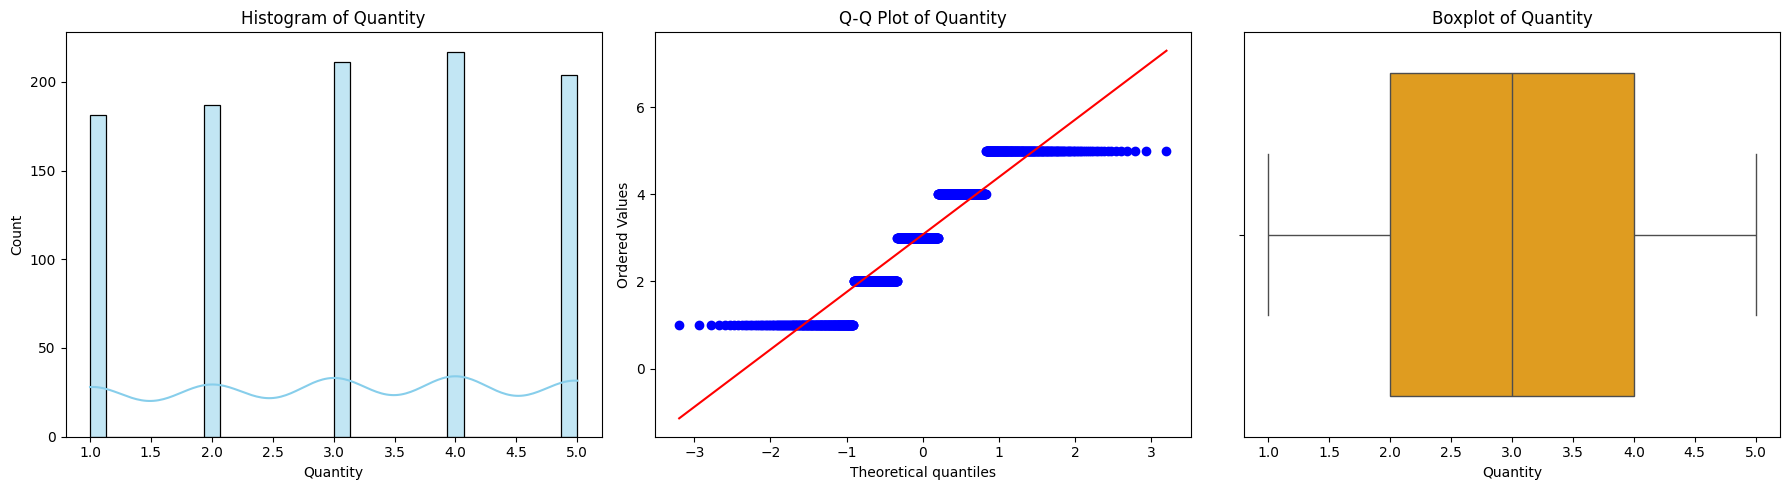

In [585]:
visualization(unsupervised_df, 'Quantity')

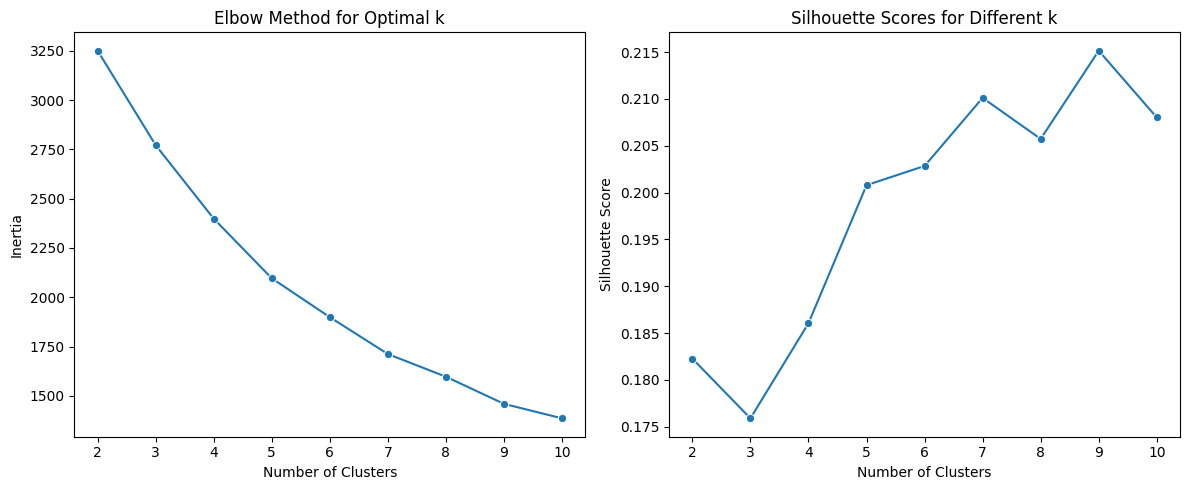

In [586]:
sample_features = scaled_features

inertias = []
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(sample_features)
    inertias.append(kmeans.inertia_)
    score = silhouette_score(sample_features, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.lineplot(x=range(2, 11), y=inertias, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
sns.lineplot(x=range(2, 11), y=silhouette_scores, marker='o')
plt.title("Silhouette Scores for Different k")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

In [587]:
optimal_k = 9
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
unsupervised_df['Spending Cluster'] = kmeans.fit_predict(scaled_features)

In [588]:
print(unsupervised_df.groupby('Spending Cluster').mean())

                  Total Purchase Amount  Product Price  Customer Age  Quantity
Spending Cluster                                                              
0                           3801.811024     267.133858     29.889764  4.267717
1                           3907.200000     309.810000     55.250000  1.370000
2                           1238.354545     202.727273     37.490909  4.500000
3                           4138.631579     116.168421     33.589474  1.705263
4                           1186.393258     124.988764     35.595506  1.876404
5                           1442.846154     347.162393     60.017094  2.683761
6                           3946.954128     378.963303     57.000000  4.201835
7                           2025.325203     399.430894     30.154472  2.528455
8                           3215.576923      99.184615     57.646154  3.769231


In [589]:
supervised_df = representative_sample[['Total Purchase Amount', 'Product Price', 'Customer Age', 'Gender','Returns', 'Churn']]
X = supervised_df[['Total Purchase Amount', 'Product Price', 'Customer Age', 'Gender','Returns' ]]
y = supervised_df['Churn']

In [590]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [591]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [592]:
print("Setelah SMOTE:")
print(f"Label 1: {sum(y_train_res == 1)}")
print(f"Label 0: {sum(y_train_res == 0)}")

Setelah SMOTE:
Label 1: 653
Label 0: 653


In [593]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [594]:
param_dist = {
    'C': uniform(loc=0.01, scale=10),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

In [595]:
logreg = LogisticRegression(random_state=42, max_iter=1000)

In [596]:
random_search = RandomizedSearchCV(
    logreg,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

In [597]:
random_search.fit(X_train_scaled, y_train_res)

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=1000, random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000012C990F2F20>,
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'saga']},
                   random_state=42, scoring='f1')

In [598]:
best_model = random_search.best_estimator_

In [599]:
y_pred = best_model.predict(X_test_scaled)

In [600]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Best Parameters:", random_search.best_params_)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Best Parameters: {'C': np.float64(2.0067378215835974), 'penalty': 'l1', 'solver': 'saga'}
Accuracy: 0.555
Precision: 0.1590909090909091
Recall: 0.4827586206896552
F1 Score: 0.23931623931623933
Confusion Matrix:
 [[97 74]
 [15 14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.57      0.69       171
           1       0.16      0.48      0.24        29

    accuracy                           0.56       200
   macro avg       0.51      0.53      0.46       200
weighted avg       0.76      0.56      0.62       200



In [601]:
import joblib
joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump(best_model, 'logreg_model.pkl')
joblib.dump(scaler, 'scaler_logreg.pkl')

['scaler_logreg.pkl']

In [602]:
!ngrok config add-authtoken 2wleSGtjtZX5282WWUfgg5eVk2T_5WEKE6o1TMifuZV5sbspV

Authtoken saved to configuration file: C:\Users\jrmas\AppData\Local/ngrok/ngrok.yml


In [ ]:
%%writefile dashboard.py

import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib

# Load data dan model
@st.cache_data
def load_data():
    df = pd.read_csv('ecommerce_customer_data_custom_ratios.csv')
    return df

kmeans = joblib.load('kmeans_model.pkl')
logreg = joblib.load('logreg_model.pkl')
scaler = joblib.load('scaler_logreg.pkl')

# Fungsi preprocessing & clustering
@st.cache_data
def preprocess_and_cluster(df):
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import KMeans
    
    # Pilih fitur untuk clustering
    unsupervised_df = df[['Total Purchase Amount', 'Product Price', 'Customer Age', 'Quantity']].copy()

    # Remove outliers IQR
    def remove_outliers_iqr(dataframe, columns):
        for col in columns:
            Q1 = dataframe[col].quantile(0.25)
            Q3 = dataframe[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            dataframe = dataframe[(dataframe[col] >= lower_bound) & (dataframe[col] <= upper_bound)]
        return dataframe

    unsupervised_df = remove_outliers_iqr(unsupervised_df, unsupervised_df.columns)
    
    # Scaling
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(unsupervised_df)

    # KMeans clustering
    kmeans = joblib.load('kmeans_model.pkl')
    clusters = kmeans.predict(scaled_features)
    unsupervised_df['Spending Cluster'] = clusters
    
    # Gabungkan kembali ke df asli sesuai index
    df = df.loc[unsupervised_df.index]
    df['Spending Cluster'] = clusters
    
    return df, kmeans

# Fungsi untuk model prediksi churn 
@st.cache_data
def load_model_and_predict(df):
    from sklearn.preprocessing import LabelEncoder
    from sklearn.linear_model import LogisticRegression
    from imblearn.over_sampling import SMOTE
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import precision_score, recall_score, f1_score

    supervised_df = df[['Total Purchase Amount', 'Product Price', 'Customer Age', 'Gender','Returns', 'Churn']].dropna()
    le = LabelEncoder()
    supervised_df['Gender'] = le.fit_transform(supervised_df['Gender'])
    X = supervised_df[['Total Purchase Amount', 'Product Price', 'Customer Age', 'Gender','Returns' ]]
    y = supervised_df['Churn']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    scaler = joblib.load('scaler_logreg.pkl')
    logreg = joblib.load('logreg_model.pkl')

    X_test_scaled = scaler.transform(X_test)

    y_pred = logreg.predict(X_test_scaled)
    y_proba = logreg.predict_proba(X_test_scaled)[:,1]

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    metrics = {
        'accuracy': logreg.score(X_test_scaled, y_test),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'confusion_matrix': cm,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'X_test': X_test
    }

    return metrics

# Streamlit Dashboard UI

st.title("Dashboard Analisis dan Prediksi Pelanggan E-Commerce")

# Load data
df = load_data()

# Sidebar filter
st.sidebar.header("Filter Data")
gender_filter = st.sidebar.multiselect("Gender", options=df['Gender'].unique(), default=df['Gender'].unique())
payment_filter = st.sidebar.multiselect("Metode Pembayaran", options=df['Payment Method'].unique() if 'Payment Method' in df.columns else [], default=df['Payment Method'].unique() if 'Payment Method' in df.columns else [])
category_filter = st.sidebar.multiselect("Kategori Produk", options=df['Product Category'].unique() if 'Product Category' in df.columns else [], default=df['Product Category'].unique() if 'Product Category' in df.columns else [])

filtered_df = df[
    (df['Gender'].isin(gender_filter)) & 
    ((df['Payment Method'].isin(payment_filter)) if 'Payment Method' in df.columns else True) &
    ((df['Product Category'].isin(category_filter)) if 'Product Category' in df.columns else True)
]

st.header("Ringkasan Data")
total_customers = filtered_df.shape[0]
avg_purchase = filtered_df['Total Purchase Amount'].mean()
churn_counts = filtered_df['Churn'].value_counts(normalize=True) if 'Churn' in filtered_df.columns else None

st.markdown(f"- **Jumlah Total Pelanggan:** {total_customers}")
st.markdown(f"- **Rata-rata Total Pembelian:** Rp {avg_purchase:,.2f}")
if churn_counts is not None:
    st.markdown(f"- **Rasio Pelanggan Churn:** {churn_counts.get(1,0)*100:.2f}%")
    st.markdown(f"- **Rasio Pelanggan Tidak Churn:** {churn_counts.get(0,0)*100:.2f}%")

# Segmentasi Pelanggan
st.header("Segmentasi Pelanggan (Clustering)")

df_clustered, kmeans = preprocess_and_cluster(filtered_df)

# Scatter plot cluster
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(data=df_clustered, x='Customer Age', y='Total Purchase Amount', hue='Spending Cluster', palette='tab10', ax=ax)
ax.set_title("Segmentasi Pelanggan Berdasarkan Usia dan Total Pembelian")
st.pyplot(fig)

# Deskripsi segmen
segmen_desc = df_clustered.groupby('Spending Cluster').agg({
    'Total Purchase Amount': 'mean',
    'Customer Age': 'mean',
    'Quantity': 'mean'
}).rename(columns={
    'Total Purchase Amount': 'Rata-rata Total Pembelian',
    'Customer Age': 'Rata-rata Usia',
    'Quantity': 'Rata-rata Kuantitas'
})
st.dataframe(segmen_desc)

# Distribusi usia dan pengeluaran per segmen
fig2, axes = plt.subplots(1, 2, figsize=(15,5))
sns.boxplot(x='Spending Cluster', y='Customer Age', data=df_clustered, ax=axes[0])
axes[0].set_title('Distribusi Usia per Segmen')
sns.boxplot(x='Spending Cluster', y='Total Purchase Amount', data=df_clustered, ax=axes[1])
axes[1].set_title('Distribusi Total Pembelian per Segmen')
st.pyplot(fig2)

# Analisis Loyalitas Pelanggan
st.header("Analisis Loyalitas Pelanggan (Prediksi Churn)")

metrics = load_model_and_predict(filtered_df)

# Tabel prediksi churn dengan probabilitas 
prediksi_df = pd.DataFrame({
    'Actual': metrics['y_test'],
    'Predicted': metrics['y_pred'],
    'Probabilitas Churn': metrics['y_proba']
}).reset_index(drop=True)
st.dataframe(prediksi_df.head(20))

# Visualisasi Confusion Matrix
fig3, ax3 = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=metrics['confusion_matrix'], display_labels=['Tidak Churn', 'Churn'])
disp.plot(ax=ax3)
st.pyplot(fig3)

# Grafik metrik evaluasi
st.subheader("Metrik Evaluasi Model")
metrics_df = pd.DataFrame({
    'Metrik': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Nilai': [metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1']]
})

fig4, ax4 = plt.subplots()
sns.barplot(x='Metrik', y='Nilai', data=metrics_df, ax=ax4)
ax4.set_ylim(0,1)
ax4.set_title("Perbandingan Metrik Evaluasi Model")
st.pyplot(fig4)

Overwriting dashboard.py


In [604]:
from pyngrok import ngrok
import threading
import time
import os
def run_streamlit():
    os.system("streamlit run dashboard.py --server.port 8501")

thread = threading.Thread(target=run_streamlit, daemon=True)
thread.start()

time.sleep(5)

public_url = ngrok.connect(addr=8501)
print(f"Streamlit dashboard is live at: {public_url}")


Streamlit dashboard is live at: NgrokTunnel: "https://cd18-2400-9800-2c8-322a-20a7-5529-f811-1fe1.ngrok-free.app" -> "http://localhost:8501"
